In [3]:
LOGS_PATH = [
    "logs/mobilefacenet-sface_KD_MSE-casia_downscale.txt",
]

train_logs = [
    {
        "epoch": [],
        "intra_loss": [],
        "inter_loss": [],
        "Wyi": [],
        "Wj": [],
        "Prec1": [],
    }
    for _ in range(len(LOGS_PATH))
]

for log_idx, log_path in enumerate(LOGS_PATH):
    with open(log_path, "r") as fi:
        while True:
            line = fi.readline()
            if line == "":
                break
            if not line.startswith("Epoch"):
                continue

            blocks = line.strip(" \n\t").split("\t")
            print(blocks)
            epoch = int(blocks[0].split(" ")[1])
            intra_loss = float(blocks[2].split(" ")[-1].strip("()"))
            inter_loss = float(blocks[3].split(" ")[-1].strip("()"))
            Wyi = float(blocks[4].split(" ")[-1].strip("()"))
            Wj = float(blocks[5].split(" ")[-1].strip("()"))
            Prec1 = float(blocks[6].split(" ")[-1].strip("()"))

            train_logs[log_idx]["epoch"].append(epoch)
            train_logs[log_idx]["intra_loss"].append(intra_loss)
            train_logs[log_idx]["inter_loss"].append(inter_loss)
            train_logs[log_idx]["Wyi"].append(Wyi)
            train_logs[log_idx]["Wj"].append(Wj)
            train_logs[log_idx]["Prec1"].append(Prec1)

        fi.close()

['Epoch 1 Batch 20', 'Speed: 126.54 samples/s', 'intra_Loss -0.6683 (-0.4936)', 'inter_Loss 18.9804 (11.3111)', 'Wyi 0.0104 (0.0077)', 'Wj 0.0004 (0.0001)', 'Prec@1 0.000 (0.020)']
['Epoch 1 Batch 40', 'Speed: 145.74 samples/s', 'intra_Loss -2.4709 (-1.2813)', 'inter_Loss 30.4372 (24.6541)', 'Wyi 0.0386 (0.0200)', 'Wj 0.0016 (0.0010)', 'Prec@1 0.000 (0.059)']
['Epoch 1 Batch 60', 'Speed: 139.48 samples/s', 'intra_Loss -3.6905 (-2.4668)', 'inter_Loss 30.6614 (27.4000)', 'Wyi 0.0577 (0.0385)', 'Wj 0.0007 (0.0014)', 'Prec@1 0.391 (0.098)']
['Epoch 1 Batch 80', 'Speed: 130.40 samples/s', 'intra_Loss -4.1658 (-3.4863)', 'inter_Loss 26.9932 (27.5720)', 'Wyi 0.0651 (0.0545)', 'Wj -0.0039 (-0.0015)', 'Prec@1 1.172 (0.293)']
['Epoch 1 Batch 100', 'Speed: 133.52 samples/s', 'intra_Loss -3.8413 (-3.9299)', 'inter_Loss 26.1349 (26.3124)', 'Wyi 0.0600 (0.0614)', 'Wj -0.0082 (-0.0063)', 'Prec@1 0.391 (0.332)']
['Epoch 1 Batch 120', 'Speed: 133.74 samples/s', 'intra_Loss -4.6779 (-4.6078)', 'inter_Lo

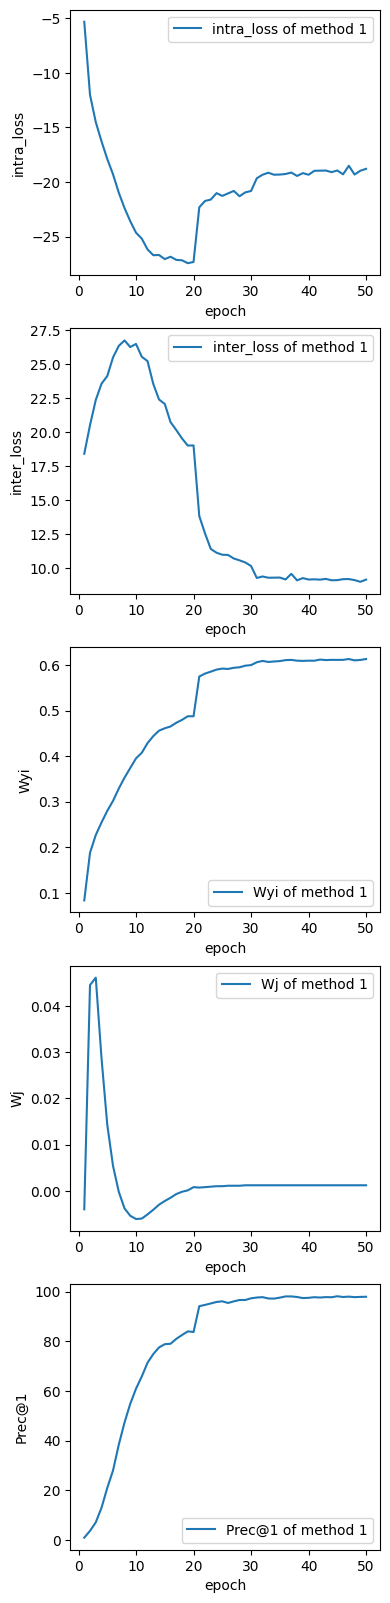

In [4]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(5, 1, figsize=(4, 20))

for log_idx, log_path in enumerate(LOGS_PATH):
    train_log = train_logs[log_idx]
    log = {
        "epoch": [],
        "intra_loss": [],
        "inter_loss": [],
        "Wyi": [],
        "Wj": [],
        "Prec@1": [],
    }

    for epoch in range(1, 51):
        train_log["epoch"].reverse()
        idx = (len(train_log["epoch"]) - 1) - train_log["epoch"].index(epoch)
        train_log["epoch"].reverse()

        log["epoch"].append(train_log["epoch"][idx])
        log["intra_loss"].append(train_log["intra_loss"][idx])
        log["inter_loss"].append(train_log["inter_loss"][idx])
        log["Wyi"].append(train_log["Wyi"][idx])
        log["Wj"].append(train_log["Wj"][idx])
        log["Prec@1"].append(train_log["Prec1"][idx])

    axs[0].plot(
        log["epoch"], log["intra_loss"], label=f"intra_loss of method {log_idx + 1}"
    )
    axs[1].plot(
        log["epoch"], log["inter_loss"], label=f"inter_loss of method {log_idx + 1}"
    )
    axs[2].plot(log["epoch"], log["Wyi"], label=f"Wyi of method {log_idx + 1}")
    axs[3].plot(log["epoch"], log["Wj"], label=f"Wj of method {log_idx + 1}")
    axs[4].plot(log["epoch"], log["Prec@1"], label=f"Prec@1 of method {log_idx + 1}")
    for idx, ax in enumerate(axs):
        ax.legend()
        ax.set_xlabel("epoch")
        ax.set_ylabel(f"{list(log.keys())[idx + 1]}")

In [2]:
import torch
from backbone.model_mobilefacenet import MobileFaceNet

backbone = MobileFaceNet(128)
backbone.load_state_dict(torch.load("weights/Backbone_MobileFaceNet_KD_CE.pth"))
backbone.eval()

image_tensor = torch.randn(1, 3, 112, 112)

onnx_program = torch.onnx.export(
    backbone,
    image_tensor,
    dynamo=True,
    export_params=True,
    do_constant_folding=True,
    input_names=["input"],
    output_names=["output"],
)
onnx_program.optimize()
onnx_program.save("weights/Backbone_MobileFaceNet_KD_CE.onnx")

/home/hazzu/Code/thesis/.conda/lib/python3.12/site-packages/onnxscript/converter.py:816: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
/home/hazzu/Code/thesis/.conda/lib/python3.12/site-packages/onnxscript/converter.py:816: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()


[torch.onnx] Obtain model graph for `MobileFaceNet([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `MobileFaceNet([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅


In [ ]:
# import onnx

# model = onnx.load("weights/face_recognition_sface_2021dec.onnx")
# inter_layers = ["conv_14_relu"]

# value_info_protos = []
# shape_info = onnx.shape_inference.infer_shapes(model)
# for idx, node in enumerate(shape_info.graph.value_info):
#     if node.name in inter_layers:
#         # print(idx, node)
#         value_info_protos.append(node)

# assert len(value_info_protos) == len(inter_layers)
# model.graph.output.extend(value_info_protos)
# onnx.checker.check_model(model)
# onnx.save(model, "weights/face_recognition_sface_2021dec_extend.onnx")

In [ ]:
import torch
import onnxruntime as ort
from onnx2torch import convert

model = convert("weights/face_recognition_sface_2021dec_extend.onnx")
model.eval()

data_input = torch.randn(1, 3, 112, 112)
print(model(data_input)[1].shape)

# session = ort.InferenceSession("weights/face_recognition_sface_2021dec_extend.onnx")
# outputs = session.run(["conv_14_relu"], {"data": data_input})
# print(outputs[0].shape)

torch.Size([1, 1024, 7, 7])
